In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = 'drive/MyDrive/505/final/'

In [ ]:
data_dir = 'drive/MyDrive/505/final/'

In [ ]:
df = pd.read_csv(data_dir + 'sample.csv', header=None)

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

Num GPUs Available:  0


In [13]:
df = pd.read_csv('../dataset/llm-detect-ai-generated-text/shuffled_GPT_wiki_intro.csv', header=None)

C:\Users\17569\AppData\Local\Temp\ipykernel_12652\185645508.py:1: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../dataset/llm-detect-ai-generated-text/shuffled_GPT_wiki_intro.csv', header=None)


In [7]:
print(df.iloc[1:10,:])


   0                                                  1  2
1  0  Hope (born 2010) is a bottlenose dolphin who i...  1
2  1  The Invasion of Umuahia (December 20-December ...  0
3  2  Morgan Adokwei Brown is a lawyer and human rig...  1
4  3  Martine Warmann (formerly Martine George; born...  1
5  4  The Last Face is a 2016 American drama film wr...  1
6  5  Placental mammals (infraclass Placentalia ) ar...  0
7  6  The People's Secretariat of Ukraine was the hi...  1
8  7  Slavic paganism or Slavic religion describes t...  1
9  8  Lieutenant Colonel John Thomas Eustace (March ...  1


In [14]:
df= df[0:200000]

In [15]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# 文本预处理
max_words = 15000  # 仅使用最常见的10000个词
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data.iloc[:, 1])  # 第三列是文本

X_train = tokenizer.texts_to_sequences(train_data.iloc[:, 1])
X_test = tokenizer.texts_to_sequences(test_data.iloc[:, 1])

In [16]:
max_sequence_length = max(len(seq) for seq in X_train)
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

# 标签预处理
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data.iloc[:, 2])  # 第二列是标签
y_test = label_encoder.transform(test_data.iloc[:, 2])

Epoch 1/3
4000/4000 [==============================] - 827s 206ms/step - loss: 0.1970 - accuracy: 0.9224 - val_loss: 0.1316 - val_accuracy: 0.9527
Epoch 2/3
4000/4000 [==============================] - 843s 211ms/step - loss: 0.0976 - accuracy: 0.9654 - val_loss: 0.1347 - val_accuracy: 0.9525
Epoch 3/3
1250/1250 [==============================] - 90s 72ms/step - loss: 0.1184 - accuracy: 0.9622
Test Accuracy: 96.22%
Training Time: 2491.20 seconds


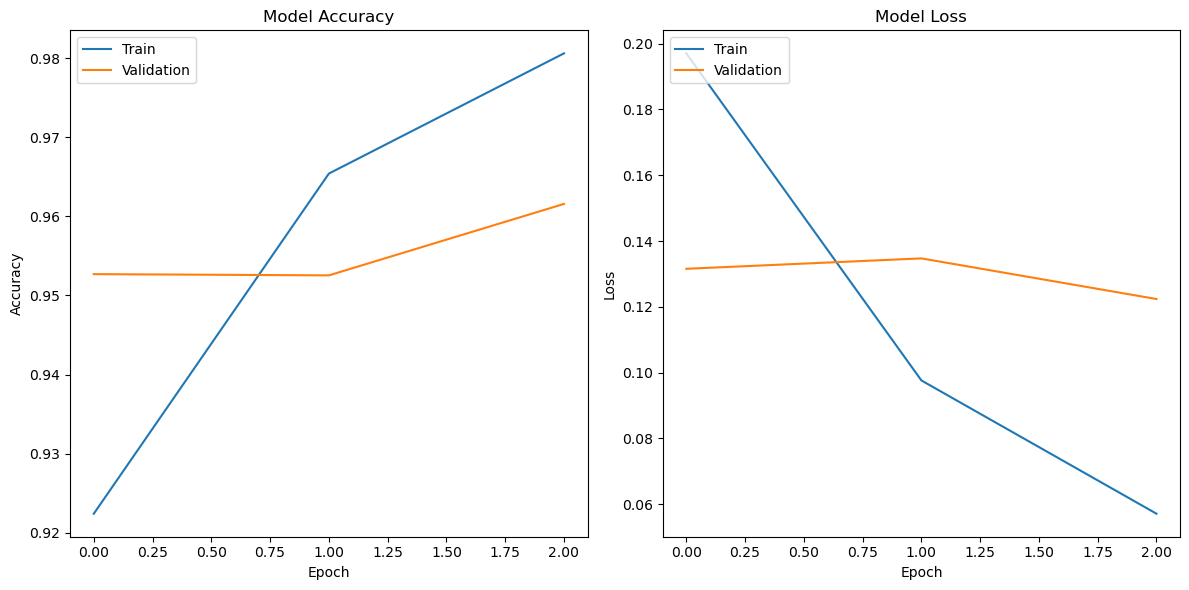

In [17]:
from tensorflow.python.keras.callbacks import ModelCheckpoint
import time
import matplotlib.pyplot as plt


# Assuming you have already defined X_train, y_train, X_test, y_test, max_words, and max_sequence_length

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=hidden_units))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Record the start time
start_time = time.time()

# Train the model and store the history
history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.2)

# Record the end time
end_time = time.time()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Calculate and print the training time
training_time = end_time - start_time
print(f'Training Time: {training_time:.2f} seconds')

# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [19]:
from keras.models import save_model, load_model

# 保存模型
model.save('lstm_model.h5')

# 加载模型
loaded_model = load_model('lstm_model.h5')

# 使用加载的模型进行预测或其他操作
loss, accuracy = loaded_model.evaluate(X_test, y_test)

1250/1250 [==============================] - 88s 70ms/step - loss: 0.1184 - accuracy: 0.9622


In [21]:
test_df = pd.read_csv('../dataset/llm-detect-ai-generated-text/shuffled_GPT_wiki_intro.csv', header=None)[200001:]
print(test_df.shape)

(100000, 3)


C:\Users\17569\AppData\Local\Temp\ipykernel_12652\1910811553.py:1: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('../dataset/llm-detect-ai-generated-text/shuffled_GPT_wiki_intro.csv', header=None)[200001:]


In [26]:
print(test_df.iloc[1,1:])

1    Arcturus is a village in the province of Masho...
2                                                    0
Name: 200002, dtype: object


In [28]:
sampled_df = test_df.sample(n=400).iloc[:,1:] # You can set a different random_state for reproducibility

# Save the sampled data to a new CSV file
sampled_df.to_csv('final_test_set.csv', index=False)

# Print the shape of the sampled dataframe
print("Sampled DataFrame Shape:", sampled_df.shape)

Sampled DataFrame Shape: (400, 2)


In [48]:
loaded_model = load_model('lstm_model.h5')

final_test_data = pd.read_csv('../dataset/testing_set/final_test_set.csv')

X_test  = pad_sequences(tokenizer.texts_to_sequences(final_test_data.iloc[:,0])  , maxlen=max_sequence_length)


y_test = label_encoder.transform(final_test_data.iloc[:,1].astype(str))


# 使用加载的模型进行预测或其他操作
loss, accuracy = loaded_model.evaluate(X_test, y_test)

13/13 [==============================] - 1s 65ms/step - loss: 0.1197 - accuracy: 0.9550
